In [5]:
from scipy.special import erf
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

def pdist(x):
    return 2*tfd.MultivariateNormalFullCovariance([1.0,2.0],[[2.0,.5],[.5,1.0]]).prob(x)+tfd.MultivariateNormalFullCovariance([3.0,4.0],[[1.0,0],[0,0.5]]).prob(x)
def logpdist(x):
    logp = tf.math.log(1e-30+pdist(x))
    assert np.all(np.isfinite(logp))
    return logp

discrepancy_fn = tfp.vi.kl_reverse
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
mu = tf.Variable([0.0,0.0],dtype=tf.float32)
scale = tf.Variable([[20.0,0],[0,20.0]],dtype=tf.float32)

for it in range(1000):
    with tf.GradientTape() as tape:
        surrogate_posterior = tfd.MultivariateNormalTriL(mu,scale_tril=scale)
        elbo_loss = tfp.vi.monte_carlo_variational_loss(logpdist,surrogate_posterior,sample_size=1000,discrepancy_fn=discrepancy_fn) #,use_reparametrization=True)
    gradients = tape.gradient(elbo_loss, [mu,scale])
    optimizer.apply_gradients(zip(gradients, [mu,scale]))
    #if it%50==0: print("%0.3f, %0.3f, %0.3f" % (scale.numpy()[0,0],mu.numpy()[0],elbo_loss.numpy()))


In [7]:
def drawellipse(mu,cov,col='k'):
    """
    mu = mean vector
    cov = covariance matrix
    col = colour
    """
    #based on https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipses-in-a-sccatterplot-using-matplotlib
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    from matplotlib.patches import Ellipse
    import matplotlib.pyplot as plt
    ax = plt.subplot(111, aspect='equal')

    for j in [2]:
        ell = Ellipse(xy=mu,
                      width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])),color=col,lw=2)
        ell.set_facecolor('none')
        ax.add_artist(ell)

(-2, 7)

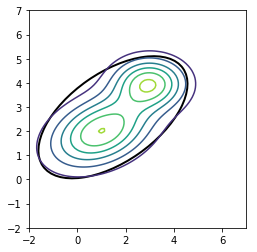

In [8]:
delta = 0.1
x = np.arange(-5.0, 10.0, delta)
y = np.arange(-5.0, 10.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2
cov = scale.numpy() @ scale.numpy().T

drawellipse(mu.numpy(),cov,'k')
plt.contour(x,y,pdist(np.vstack([X.flatten(),Y.flatten()]).T).numpy().reshape(X.shape[0],X.shape[1]))
plt.xlim([-2,7])
plt.ylim([-2,7])